In [23]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import sys
import pickle
from datetime import datetime, timedelta

sys.path.append('/home/a1jadhav/pfm_root/PFM/sdpm_py_util')

import grid_functions as grdfuns
import plotting_functions as pltfuns

In [9]:
file_path = '/home/ffeddersen/PFM/driver/test_of_ncks.nc'
his_filepath = '/scratch/matt/sdtjre_L1/I06J18/ocean_his_LV1_20192020.nc'
fngr = '/home/mspydell/models/SDPM_root/SDPM/grids/GRID_SDTJRE_LV1.nc'
RMG = grdfuns.roms_grid_to_dict(fngr)

fnout='/scratch/PFM_Simulations/LV1_Forecast/Forc/ocn_dict_file_2024-07-29T12:00.pkl'
with open(fnout,'rb') as fp:
            OCN = pickle.load(fp)
            print('OCN dict loaded with pickle')

OCN dict loaded with pickle


In [10]:
OCN

{'vinfo': {'lon': {'long_name': 'longitude', 'units': 'degrees_east'},
  'lat': {'long_name': 'latitude', 'units': 'degrees_north'},
  'ocean_time': {'long_name': 'time since initialization',
   'units': 'days',
   'coordinates': 'temp_time',
   'field': 'ocean_time, scalar, series'},
  'surf_el': {},
  'water_u': {},
  'water_v': {},
  'temp': {'long_name': 'ocean temperature',
   'units': 'degrees C',
   'coordinates': 'z,lat,lon',
   'time': 'ocean_time'},
  'sal': {},
  'ocean_time_ref': {'long_name': 'the reference date tref (initialization time)'},
  'depth': {'long_name': 'ocean depth', 'units': 'm'},
  'salt': {'long_name': 'ocean salinity',
   'units': 'psu',
   'coordinates': 'z,lat,lon',
   'time': 'ocean_time'},
  'u': {'long_name': 'ocean east west velocity',
   'units': 'm/s',
   'coordinates': 'z,lat,lon',
   'time': 'ocean_time'},
  'v': {'long_name': 'ocean north south velocity',
   'units': 'm/s',
   'coordinates': 'z,lat,lon',
   'time': 'ocean_time'},
  'zeta': {'lo

In [36]:
def plot_ocn_fields_from_dict(OCN, RMG, fields_to_plot=None, show=False):
    """
    Plot specified fields from a dictionary and save them as PNG files.
    
    Parameters:
    OCN (dict): Dictionary containing the data fields.
    fields_to_plot (list or str): The fields to plot. If None, plot all fields.
    """
    # Extract the common variables
    # timestamp = pltfuns.extract_timestamp_1999(OCN)
    lon = OCN['lon'][:]
    lat = OCN['lat'][:]
    ocean_time = OCN['ocean_time']
    start_time = datetime(1999, 1, 1) + timedelta(days=float(ocean_time[0]))

    if fields_to_plot is None:
        fields_to_plot = ['velocity', 'surf_el', 'water_temp', 'salinity']
    else:
        fields_to_plot = [fields_to_plot] if isinstance(fields_to_plot, str) else fields_to_plot

    for field in fields_to_plot:
        fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': ccrs.PlateCarree()})
        cmap = plt.get_cmap('turbo')
        plt.set_cmap(cmap)

        if field == 'velocity':
            u = OCN['u'][0, 0, :, :]  # surface layer
            v = OCN['v'][0, 0, :, :]  # surface layer
            magnitude = np.sqrt(u**2 + v**2)
            plevs = np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 50)
            cset = ax.contourf(lon, lat, magnitude, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            ax.quiver(lon[::5], lat[::5], u[::5, ::5], v[::5, ::5], transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Velocity Magnitude [m/s]')
            cbar.set_ticks(np.linspace(np.nanmin(magnitude), np.nanmax(magnitude), 5))
            ax.set_title('Surface Velocity [m/s]')
        
        elif field == 'surf_el':
            surf_el = OCN['zeta'][0, :, :]
            plevs = np.linspace(np.nanmin(surf_el), np.nanmax(surf_el), 50)
            cset = ax.contourf(lon, lat, surf_el, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Elevation [m]')
            cbar.set_ticks(np.linspace(np.nanmin(surf_el), np.nanmax(surf_el), 5))
            ax.set_title('Surface Elevation [m]')
        
        elif field == 'water_temp':
            water_temp = OCN['temp'][0, 0, :, :]
            plevs = np.linspace(np.nanmin(water_temp), np.nanmax(water_temp), 50)
            cset = ax.contourf(lon, lat, water_temp, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_label('Surface Temperature [°C]')
            cbar.set_ticks(np.linspace(np.nanmin(water_temp), np.nanmax(water_temp), 5))
            ax.set_title('Surface Temperature [°C]')
        
        elif field == 'salinity':
            salinity = OCN['salt'][0, 0, :, :]
            plevs = np.linspace(np.nanmin(salinity), np.nanmax(salinity), 50)
            cset = ax.contourf(lon, lat, salinity, plevs, cmap=cmap, transform=ccrs.PlateCarree())
            cbar = fig.colorbar(cset, ax=ax, orientation='horizontal', pad=0.05)
            cbar.set_ticks(np.linspace(np.nanmin(salinity), np.nanmax(salinity), 5))
            cbar.set_label('Salinity [psu]')
            ax.set_title('Surface Salinity [psu]')
        
        # Add coastlines and gridlines and ROMS box
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black')
        ax.grid(True)
        pltfuns.plot_roms_box(ax, RMG)
        ax.set_aspect('auto')
        ax.set_xticks(np.round(np.linspace(np.min(lon), np.max(lon), num=5), 2))
        ax.set_yticks(np.round(np.linspace(np.min(lat), np.max(lat), num=5), 2))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
        
        # Set the title and labels
        annotation = f'Timestamp: {start_time.strftime("%Y-%m-%d %H:%M:%S")} | Model: Hycom | Field: {field}'
        ax.text(0.5, 1.05, annotation, transform=ax.transAxes, ha='center', fontsize=12)
        
        
        # for field in fields_to_plot:
        #     if show is True:
        #         output_dir = PFM['lv1_plot_dir']
        #         filename = f'{output_dir}/{timestamp}_hycom_OCN_{field}.png'
        #         plt.savefig(filename, dpi=300)
        #         plt.show()
        #     else:
        plt.show()
        plt.close()

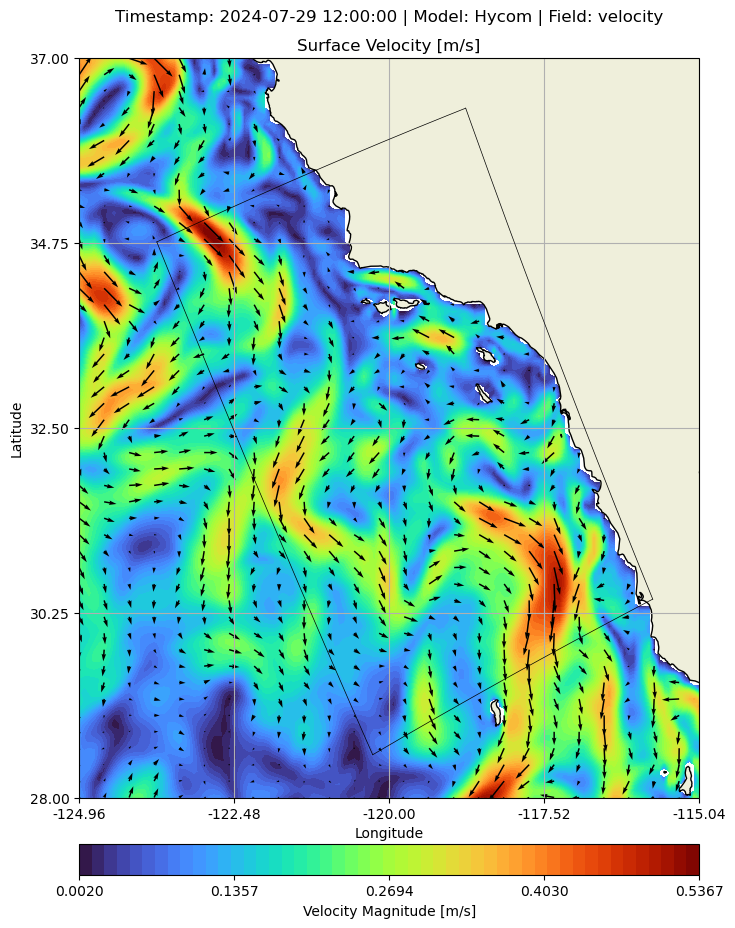

In [39]:
plot_ocn_fields_from_dict(OCN, RMG,'velocity')

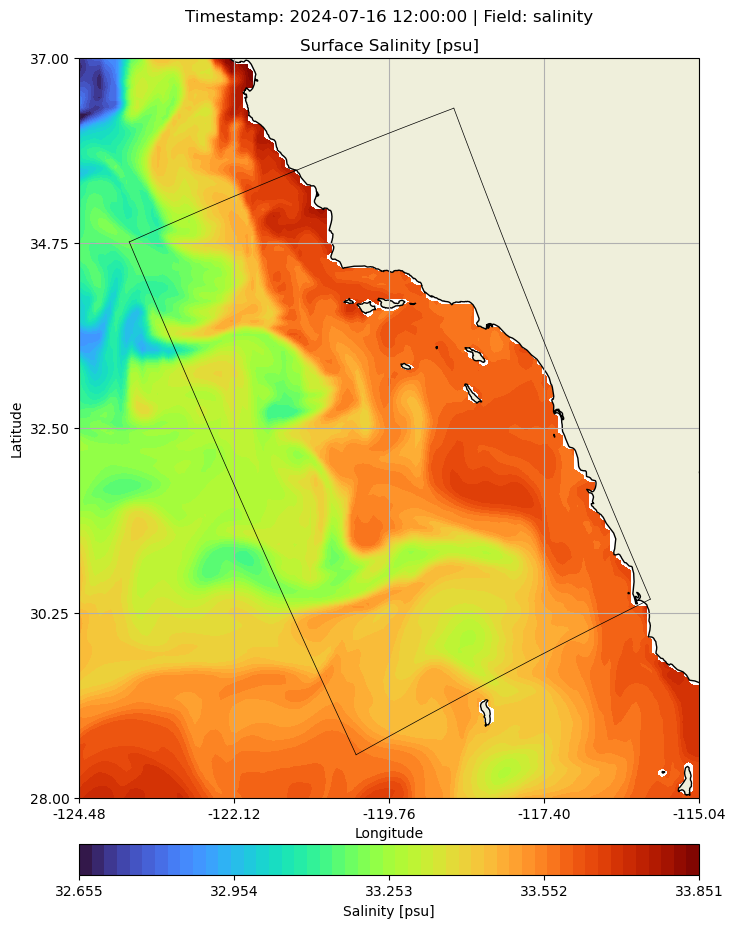

In [3]:
pltfuns.plot_ocn_fields_from_nc(file_path, RMG, 'salinity')

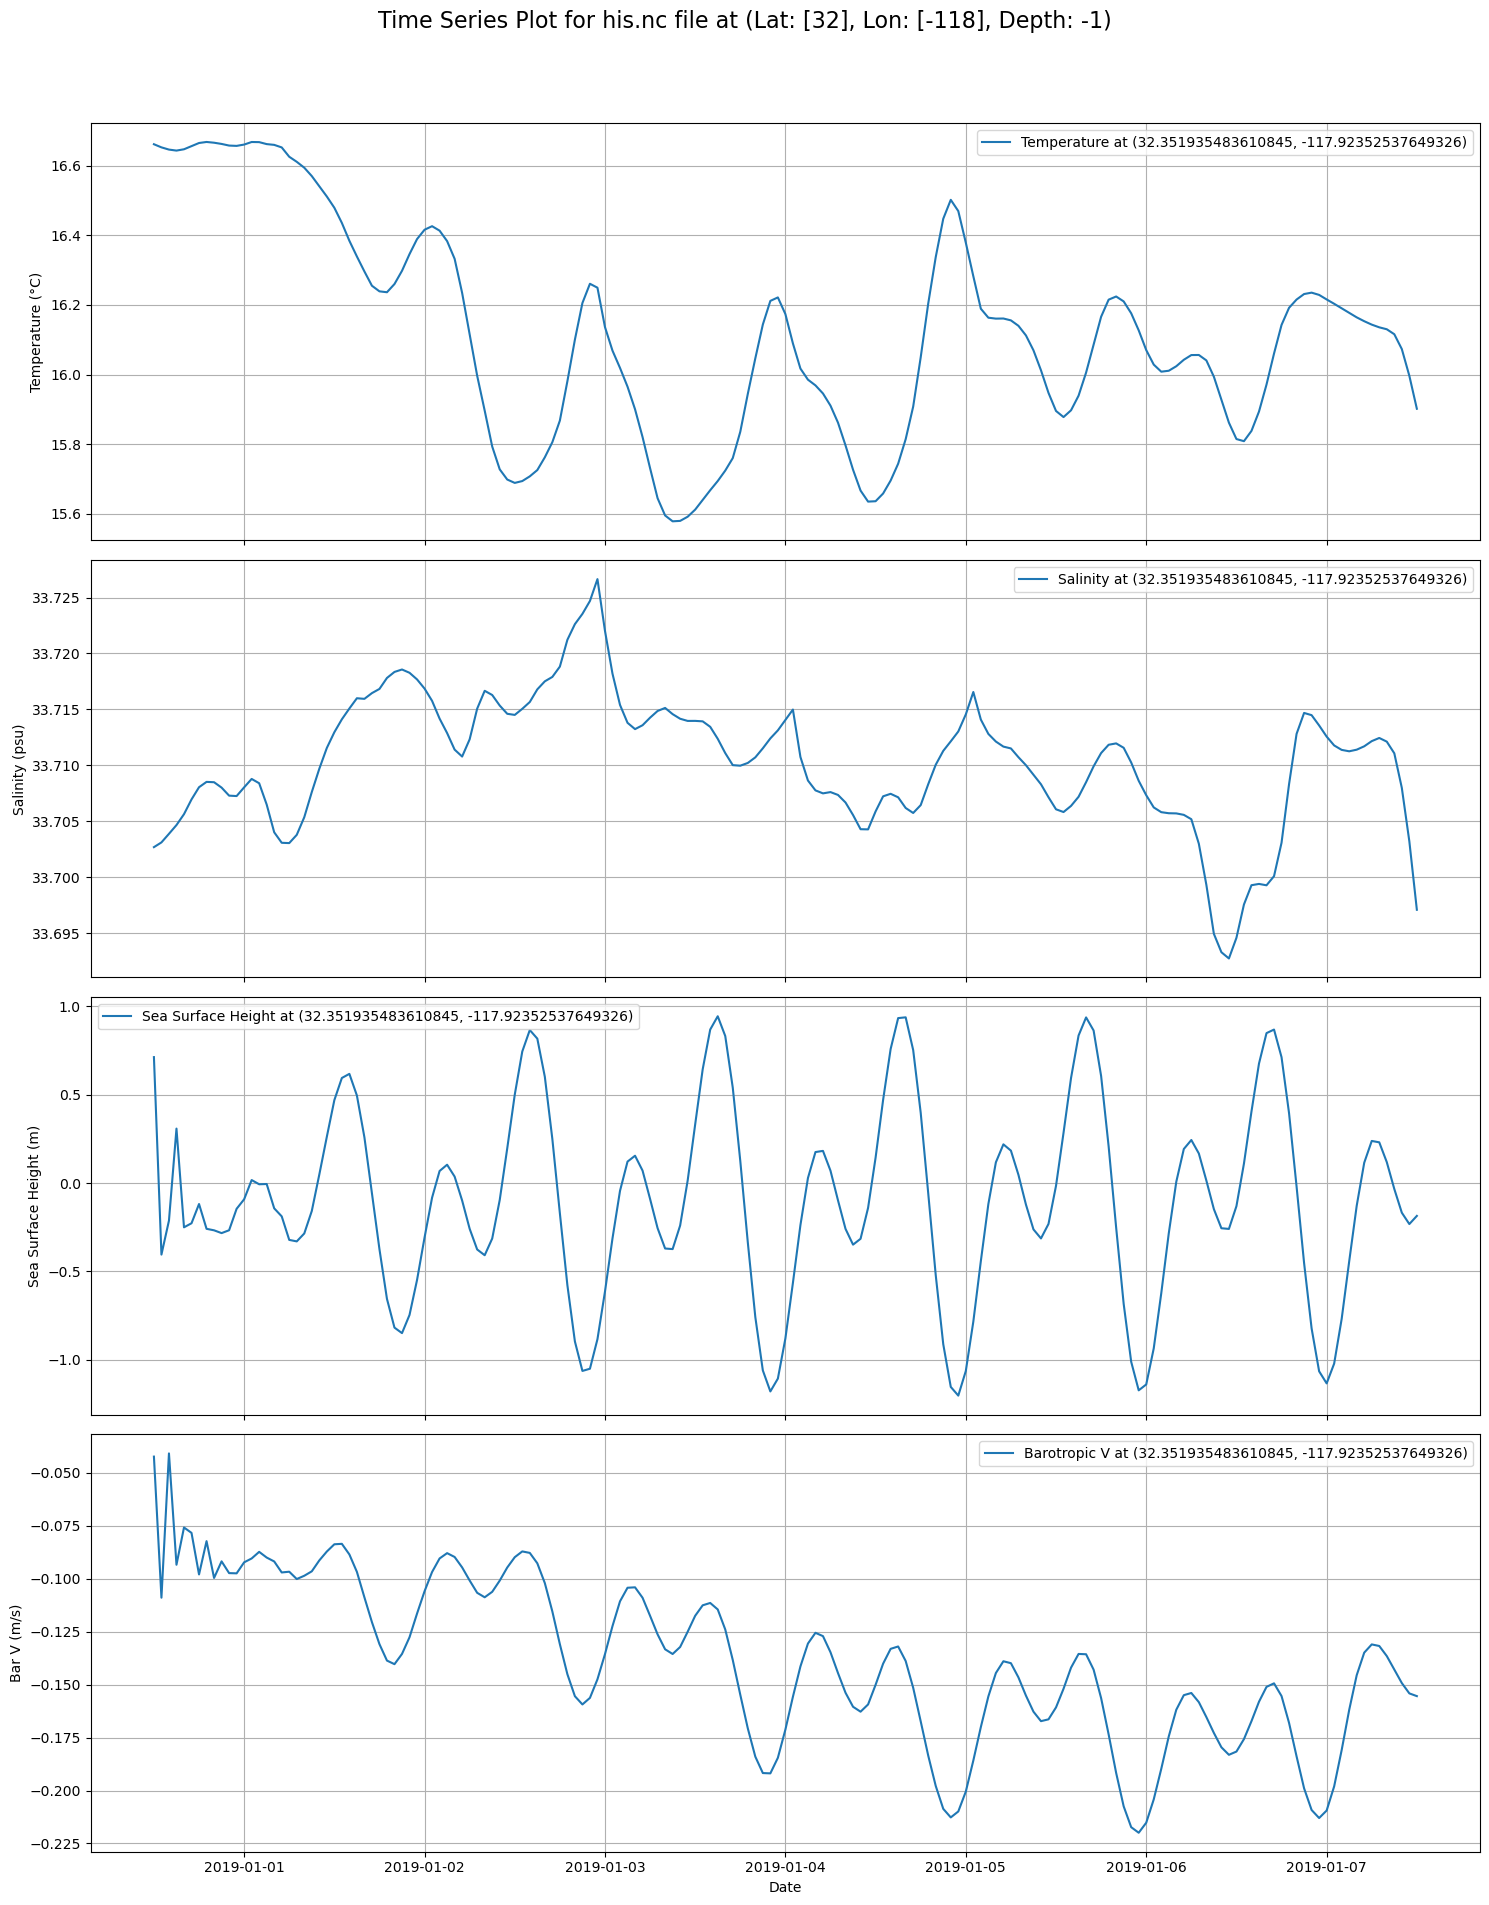

In [6]:
lats = [32]  # Replace with actual latitudes
lons = [-118]  # Replace with actual longitudes
pltfuns.plot_his_time_series(his_filepath, RMG, lats, lons)